### The Gaussian quadrature method

It computes the definite integral of a function $f(x)$ between $[-1, 1]$, through
$$
\int_{-1}^{1} f(x) \, dx \approx \sum_{i=1}^n w_i f(x_i)
$$
where the approximation becomes equality if $f(x)$ is a polynomial of degree equal or less to $2n - 1$

In [ ]:
# The Gauss-Legendre quadrature rule is the most basic
# Gauss-Jacobi increases accuracy
# Gauss-Laguerre for semi-infinite
# Guass-Hermite for infinite intervals




In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt

# change to latex rendering
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

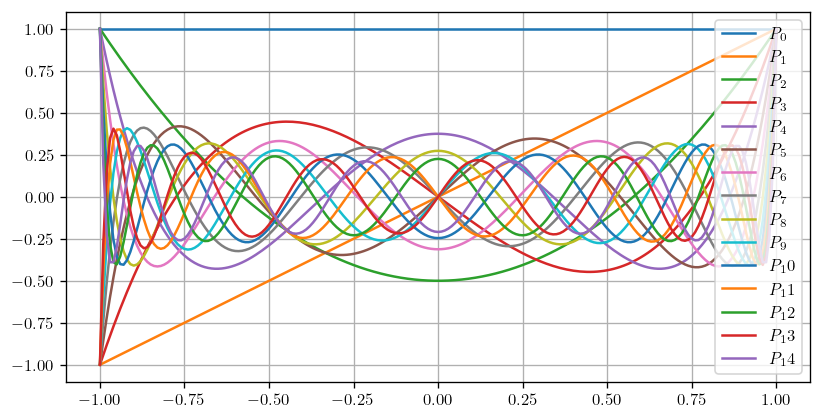

In [7]:

from typing import Union


# create Legendre Polynominal

# [c0, c1, c2, ..., cn-1]
# of degree N=len
Poly = list[float]


# numeric polynomial multiplication
def polymul(p1: Poly, p2: Poly) -> Poly:
    result = [0.0] * (len(p1) + len(p2) - 1)

    for i2 in range(len(p2)):
        for i1 in range(len(p1)):
            result[i2+i1] += p2[i2] * p1[i1]

    return result


# integrate the polynomial, this is not used
def polyintegrate(p: Poly) -> Poly:
    result = [0, *p]

    for i in range(len(p)):
        result[i+1] /= (i+1)
    
    # this ignores the constant term, which is 0.0
    return result

# evaluate the polynomial at two points and subtract their components?
def polyeval2(p: Poly, upper: float, lower: float) -> Poly:
    result = [*p]
    
    for i in range(len(p)):
        result[i] *= (upper ** i - lower ** i)
    
    return result

# evaluate the polynomial at *x*
def polyeval(p: Poly, x: float) -> float:
    return sum(
        map(lambda r: r[1] * x ** r[0], enumerate(p))
    )

# memoization
def memo(fn):
    storage = {}

    def wrapper(*args):
        # try the memory
        if args in storage:
            return storage[args]

        # else execute and stpre
        output = fn(*args)
        storage[args] = output
        return output

    return wrapper

@memo
def legendre_polynominals(n: int) -> Poly:
    if n == 0:
        return [1]

    if n == 1:
        return [0, 1]

    # Av = b
    # where dim A = (N+1) x (N+1)
    # dim b = N + 1

    # construct A
    A = []

    # first add the inner product equations with Pi, 0 <= i < n
    for m in range(n):
        Pm = legendre_polynominals(m)

        # compute the linear equations of n+1 variables
        # c0 ... cn-1
        coefs = [0] * (n+1)
        for ci in range(n+1):
            coef = 0
            for i, c in enumerate(Pm):
                deg = ci + i + 1  # additional 1 degree from integration
                # the c_{ci} term mul by (1^deg - (-1)^deg) / deg due to integration
                coef += c * (1 ** deg - (-1) ** deg) / deg

            coefs[ci] = coef

        A.append(coefs)

    # add the Pn(1) = 1
    A.append([1.0] * (n + 1))

    # Add the expected result: n inner product orthogonality + one Pn(1) = 1
    b = [0] * n + [1]

    coef = np.linalg.solve(
        np.array(A),
        np.array(b)
    )

    return coef





def graph_legendre():
    fig, ax = plt.subplots(figsize=(8, 4), dpi=120)

    xs = np.arange(-1, 1.01, 0.01)

    N = 15
    for n in range(N):
        poly = legendre_polynominals(n)

        ys = []
        for x in xs:
            ys.append(polyeval(poly, x))

        ax.plot(xs, ys, label=f"$P_{n}$")


    ax.grid()
    ax.legend()
    # plt.legends()
    # fig.show()


graph_legendre()



# legendre_polynominals(2)

In [8]:
from fractions import Fraction
from IPython.display import display, Math

def polydisplay(p: Poly):
    eps = 0.001

    coef = []
    for i, c in enumerate(p):
        # skip zeros
        if abs(c) < eps:
            continue
        
        if i == 0:
            postfix = ""
        elif i == 1:
            postfix = "x"
        else:
            postfix = f"x^{{{i}}}"

        if (abs(c) - 1) < eps and i != 0:
            prefix = ""
        elif isinstance(c, int) or c.is_integer():
            prefix = str(c)
        else:
            frac = Fraction(c).limit_denominator()
            num, denom = frac.as_integer_ratio()
            prefix = f"\\frac{{{num}}}{{{denom}}}"

        coef.append(f"{prefix}{postfix}")
    
    return " + ".join(reversed(coef))


def compute_legendre(upper: int):
    outputs = [
        polydisplay(legendre_polynominals(n))
        for n in range(upper+1)
    ]

    for n in range(upper+1):
        output = polydisplay(legendre_polynominals(n))
        display(Math(f"P_{{{n}}}(x) = {output}"))


compute_legendre(20)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [9]:
from typing import Callable

def filter_dupes(items, tol):
    results = []
    for item in items:
        condition = any(map(lambda x: abs(x - item) < tol, results))
        if not condition:
            results.append(item)

    return results


# Newton's root finding method
def solveN(
    equ: Callable[[float], float], 
    deriv: Callable[[float], float],
    lower: float, upper: float,
    roots: int = np.inf,
    min_points: int = 100,
    max_points: int = 100000,
    iter_points: int = 10,
    max_iter: int = 100,
    tol: float = 1e-6
) -> np.ndarray:
    found_roots = 0
    best_roots = []

    for points in np.linspace(min_points, max_points, iter_points):
        xs = np.linspace(lower, upper, min_points)

        # run newton's method on xs
        for i in range(max_iter):

            # update all
            new_xs = xs - equ(xs) / deriv(xs)

            # check bounds
            norm = np.abs(new_xs - xs)

            # the new roots & cleanup duplicates
            new_roots = filter_dupes(new_xs[norm < tol], 2*tol)

            xs = new_xs

            # check roots count
            found_roots = len(new_roots)
            best_roots = new_roots

            if found_roots >= roots:
                break

        else:
            # no best roots found
            continue

        break
    else:
        print('warning, not enough roots found')        


    return best_roots


# def f(x):
#     return 63/8 * x**5 - 35 / 4 * x**3 + 15/8 * x

# def df(x):
#     return 63/8 * 5 * x**4 - 35/4*3*x**2 + 15/8

# solveN(f, df, -1, 1)

### Gauss-Legendre quadrature

Given the parameters of $f(x)$ with domain $[a, b]$, sampling $n$ points, the process is
- First compute the Legendre polynominal $P_n$ coefficents
- Compute the roots $x_i$ of the polynominal 
- Then calculate the weights $w_i$
- Finally take the inner product betweeen $f(P_n(x))$ and $w$

$$

\int_{-1}^1 f(x) \, dx = \sum_{n=1}^n w_i f(x_i)

$$

#### Legendre polynominal
Has the form $P_n(x)$, and for parameters $n = 0, 1, 2, \dots$ forms a class of orthogonal polynominals.

A class of orthogonal polynominal is generally defined by its inner product
$$
    \langle f, g\rangle = \int_{-\infty}^\infty f(x) g(x) w(x) \,dx
$$
where $w(x)$ is a weights function.

For Legendre polynominals, the parameters are $w(x) = 1$ and $P_n(1)=1$.


#### Newton-Raphson method
For better guessese on the roots of function $f(x)$, iterate the following
$$
    x_{n+1} = x_n - \frac{f(x_n)}{f'(f_n)}
$$


#### Weights
The formula for the weights of the Gauss-Legendre quadrature is
$$
    w_i = \frac{2}{(1-x_i^2)\left[ P'_n(x_i) \right]^2}
$$


#### Change of Variable
To change the domain from a generic $[a,b]$ to $[-1,1]$ used in the Quadrature, utilize
$$
    \int_a^b f(x) \, dx = \int_{-1}^1 f(\frac{b-a}{2} \xi - \frac{a+b}{2}) \frac{dx}{d\xi} \, d\xi
$$
where the substitution is
$$
\begin{align*}
    x &= \frac{b-a}{2}\xi + \frac{a+b}{2} \\
    \frac{dx}{d\xi} &= \frac{b-a}{2}
\end{align*}
$$

One can verify that 
$$
\begin{align*}
    a &= \frac{b-a}{2} (-1) + \frac{a+b}{2}\\
    b &= \frac{b-a}{2} (1) + \frac{a+b}{2}
\end{align*}
$$

In [10]:
from typing import Tuple



# returns the derivative of the polynomial
def polyderiv(p: Poly) -> Poly:
    # allocate
    results = [0.0] * (len(p) - 1)

    for i, c in enumerate(p[1:]):
        results[i] = c * (i+1)

    return results



def gausslegendre(
    n,
    tol: float
) -> Tuple[np.ndarray, np.ndarray]:
    # first find the points
    poly = legendre_polynominals(n)
    diff = polyderiv(poly)

    def P(x):
        return polyeval(poly, x)

    def dPdx(x):
        return polyeval(diff, x)

    roots = np.array(solveN(
        P, dPdx,
        -1, 1,
        roots=n,
        tol=tol
    ))

    if len(roots) != n:
        raise RuntimeError('failed to find the roots for the legendre polynominals')

    # compute the weights
    weights = 2 / ((1-roots**2) * dPdx(roots)**2)

    return weights, roots


def quad(
    f: Callable[[float], float],
    a: float, b: float,
    n: int = 6,
    tol: float = 1e-6
) -> float:
    
    # change of variable
    # caching
    m, c = (b-a)/2, (a+b)/2

    weights, roots = gausslegendre(n, tol=tol)

    return m * np.dot(weights, f(m * roots + c))
    

def simplequad(f, a, b, h = 0.01):
    return sum([
        (f(x+h) + f(x)) * h / 2 for x in np.arange(a, b, h)
    ])


def f(x):
    return (x**5 - 4 + 4 * x**2) * np.exp(x)

a, b = -np.log(2), np.log(2)
print(quad(f, a, b, n=4, tol=1e-6))
print(simplequad(f, a, b, h=0.001))

-4.956944238253405
-4.959570140168684


In [36]:
import scipy.integrate as integrate

def f(x):
    return 1/(x**6 + 1)

integrate.quad(f, -np.inf, np.inf)

(2.0943951023931953, 2.128084336061663e-11)

In [23]:
2*np.pi/3

2.0943951023931953